# Image Classiﬁer 

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import random
from copy import deepcopy
import operator

### Load Data

In [2]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])

    # handle normalizing the histogram 
    cv2.normalize(hist, hist)

    # return the flattened histogram as the feature vector
    return hist.flatten()

In [3]:
# Make a list of calibration images
train_dataset = glob.glob('train/*/*.jpg')
test_dataset = glob.glob('test/*/*.jpg')

Train_Images = []
Train_features = []
Train_labels = []

for idx, fname in enumerate(train_dataset):
    img = cv2.imread(fname)
    label = idx // 100
#     resize to 16*16 ==> then flatten it 1*256
    pixels = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = extract_color_histogram(img)
    
    Train_Images.append(pixels)
    Train_features.append(hist)
    Train_labels.append(label)
    
    
Test_Images = []
Test_features = []
Test_labels = []

for idx, fname in enumerate(test_dataset):
    img = cv2.imread(fname)
    label = idx // 10
#     resize to 16*16 ==> turn it to gray and flatten it 1*256
    pixels = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = extract_color_histogram(img)
    
    Test_Images.append(pixels)
    Test_features.append(hist)
    Test_labels.append(label)

## Show some of image

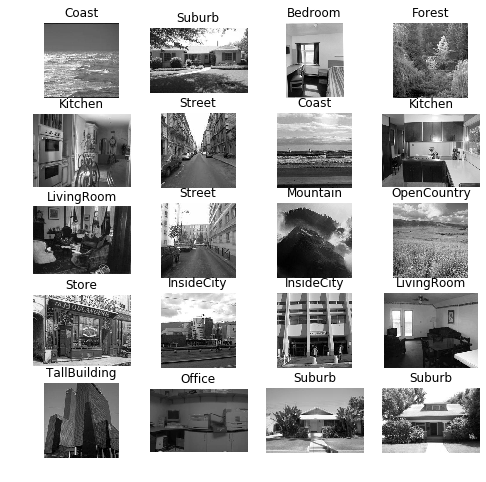

In [4]:
labels_map = {0 : 'Bedroom', 1 : 'Coast', 2 : 'Forest', 3 : 'Highway', 4 : 'Industrial', 5 : 'InsideCity', 6 : 'Kitchen',
              7 : 'LivingRoom', 8 : 'Mountain', 9 : 'Office', 10 : 'OpenCountry', 11 : 'Store', 12 : 'Street', 13 : 'Suburb',
              14 : 'TallBuilding'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(Train_Images))
    img = Train_Images[img_xy]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[Train_labels[img_xy]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [5]:
def Tiny_images(ImageSet,SIZE):
    TinyImageSet = ImageSet.copy()
    for idx in range(len(ImageSet)):
        TinyImageSet[idx] = cv2.resize(ImageSet[idx], SIZE).flatten()
    return TinyImageSet

### KNN

In [6]:
class my_knn():
    # Basic KNN classifier
    def fit(self, X_train, y_train, k , l = 2):
        self.X_train = X_train
        self.y_train = y_train
        self.k = k
        self.l = l

    def euc(self, a, b):
        # Norm difference is more efficient
        return np.linalg.norm(a - b)

    def manhattan(self, a, b):
        return np.sum(np.absolute(a - b))
        
#     def closest(self, row, k):
#         # Initialize baselines
#         best_dist = self.euc(row, self.X_train[0])
#         best_index = 0

#         # If new distance is better, keep it
#         for i in range(len(self.X_train)):
#             dist = self.euc(row, self.X_train[i])
#             if dist < best_dist:
#                 best_dist = dist
#                 best_index = i
#         return self.y_train[best_index]

#     def predict(self, X_test):
#         # Use distance calculations to predict class
#         predictions = []
#         for row in X_test:
#             label = self.closest(row, self.k)
#             predictions.append(label)
#         return predictions
    
    def getAccuracy(self, testSet, predictions):
        correct = 0
        for x in range(len(testSet)):
            if testSet[x] == predictions[x]:
                correct += 1
        return round((correct/float(len(testSet))), 3)
    
    def predict2(self, X_test):
        # Use distance calculations to predict class
        predictions = []
        for row in X_test:
            neighbors = self.getNeighbors(row)
            label = classifier.getResponse(neighbors)
            predictions.append(label)
        return predictions
    
    
    def getNeighbors(self, test_set):
        distances = []
        neighbors = []

        for x in range(len(self.X_train)):
            if self.l == 2:
                dist = self.euc(test_set, self.X_train[x])
            else: 
                dist = self.manhattan(test_set, self.X_train[x])
            distances.append((self.y_train[x], dist))

        distances.sort(key=operator.itemgetter(1))

        for x in range(self.k):
            neighbors.append(distances[x][0])

        return neighbors
    
    def getResponse(self, neighbors):
        classVotes = {}
        for x in range(len(neighbors)):
            response = neighbors[x]
            if response in classVotes:
                classVotes[response] += 1
            else:
                classVotes[response] = 1
        sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
#         print(sortedVotes)
#         print(neighbors, sortedVotes[0][0])
        return sortedVotes[0][0]

## Nearest Neighbor Classiﬁer

In [7]:
SIZE = (16,16)
Tiny_Train_Images = Tiny_images(Train_Images,SIZE)
Tiny_Test_Images = Tiny_images(Test_Images,SIZE)

In [8]:
#KNN k = 1 by ourself
k = 10
classifier = my_knn()
classifier.fit(Train_features, Train_labels, k)
predictions = classifier.predict2(Test_features)
acc = classifier.getAccuracy(predictions, Test_labels)
print("histogram accuracy: {:.2f}%".format(acc * 100))


k = 6
classifier = my_knn()
classifier.fit(Tiny_Train_Images, Train_labels, k, l = 1)
predictions = classifier.predict2(Tiny_Test_Images)
acc = classifier.getAccuracy(predictions, Test_labels)
print("RawImages accuracy: {:.2f}%".format(acc * 100))

histogram accuracy: 24.00%
RawImages accuracy: 14.00%


In [9]:
#knn by sklearn
from sklearn.neighbors import KNeighborsClassifier

k = 10
model = KNeighborsClassifier(n_neighbors=k)
model.fit(Train_features, Train_labels)
acc = model.score(Test_features, Test_labels)
print("histogram accuracy: {:.2f}%".format(acc * 100))

k = 45
model = KNeighborsClassifier(n_neighbors=k, p = 1)
model.fit(Tiny_Train_Images, Train_labels)
acc = model.score(Tiny_Test_Images, Test_labels)
print("RawImages accuracy: {:.2f}%".format(acc * 100))

histogram accuracy: 24.00%
RawImages accuracy: 16.67%


## Bag of SIFT representation + nearest neighbor classiﬁer by sklearn

In [10]:
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

In [11]:
def Bag_of_SIFT(Train_Images, Train, kmeans = None):
    start = time.time()
    # List where all the descriptors are stored
    des_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    # Reading the image and calculating the features and corresponding descriptors
    for idx in range(len(Train_Images)):
        kp, desc = sift.detectAndCompute(Train_Images[idx], None)
        des_list.append(desc)  # Appending all the descriptors into the single list

    # Stack all the descriptors vertically in a numpy array
    descriptors = np.concatenate(des_list, axis=0)
        
    end = time.time()
    print('sift Time: {}s'.format(end-start))
    start = time.time()

    # Perform k-means clustering
    k = 300  # Number of clusters
    if Train == True:
        kmeans = MiniBatchKMeans(n_clusters=k).fit(descriptors)
    
    # Calculate the histogram of features
    histogram = []
    for i in range(len(Train_Images)):
        clusters = kmeans.predict(des_list[i])
        hist, _ = np.histogram(clusters, bins = k)
        histogram.append(hist)
        
    end = time.time()
    print('kmeans Time: {}s'.format(end-start))
            
    return histogram, kmeans


In [12]:
Train_Bag_of_SIFT_features, kmeans = Bag_of_SIFT(Train_Images, Train = True)

sift Time: 32.77134561538696s
kmeans Time: 78.30827474594116s


In [13]:
Test_Bag_of_SIFT_features, kmeans = Bag_of_SIFT(Test_Images,False, kmeans)

sift Time: 3.475703001022339s
kmeans Time: 0.9029626846313477s


In [14]:
model = KNeighborsClassifier(n_neighbors= 10)
model.fit(Train_Bag_of_SIFT_features, Train_labels)
acc = model.score(Test_Bag_of_SIFT_features, Test_labels)
print("Bag_of_SIFT accuracy: {:.2f}%".format(acc * 100))

Bag_of_SIFT accuracy: 32.67%


## Bag of SIFT representation + linear SVM classiﬁer 

In [15]:
from sklearn import svm

In [16]:
svm_model = svm.SVC(kernel='linear')
svm_model.fit(Train_Bag_of_SIFT_features, Train_labels)
acc = svm_model.score(Test_Bag_of_SIFT_features, Test_labels)
print("Bag_of_SIFT accuracy: {:.2f}%".format(acc * 100))

Bag_of_SIFT accuracy: 36.00%


## Bag of SIFT representation + nearest neighbor classiﬁer by ourself

### KMean 

In [17]:
def kMeans(X, k):
    centers = X[np.random.choice(np.arange(len(X)), k, replace=False)]
    centers_old = np.zeros(centers.shape) # to store old centers
    centers_new = deepcopy(centers) # Store new centers

    n = len(X)
    clusters = np.zeros((n,128))
    distances = np.zeros((n,k))

    error = np.linalg.norm(centers_new - centers_old)
    itr = 0
    max_iter = 20

    # When, after an update, the estimate of that center stays the same, exit loop
    while error != 0 and itr < max_iter:
        # Measure the distance to every center
        for i in range(k):
            distances[:,i] = np.linalg.norm(X - centers[i], axis=1)
        # Assign all training data to closest center
        clusters = np.argmin(distances, axis = 1)

        if (len(np.unique(clusters)) < k):
            centers_new = X[np.random.choice(np.arange(len(X)), k, replace=False)]
        else:
            centers_old = deepcopy(centers_new)
            # Calculate mean for every cluster and update the center
            for i in range(k):
                centers_new[i] = np.mean(X[clusters == i], axis=0)
        error = np.linalg.norm(centers_new - centers_old)
        itr = itr + 1
        
    return centers_new, clusters 

def kMeans_predict(X, centers, k=300):
    n = len(X)
    clusters = np.zeros((n,128))
    distances = np.zeros((n,k))
    for i in range(k):
        distances[:,i] = np.linalg.norm(X - centers[i], axis=1)
        # Assign all training data to closest center
    clusters = np.argmin(distances, axis = 1)
    return clusters

def Bag_of_SIFT2(Train_Images, Train, centroids = None):
    start = time.time()
    # List where all the descriptors are stored
    des_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    # Reading the image and calculating the features and corresponding descriptors
    for idx in range(len(Train_Images)):
        kp, desc = sift.detectAndCompute(Train_Images[idx], None)
        des_list.append(desc)  # Appending all the descriptors into the single list

    # Stack all the descriptors vertically in a numpy array
    descriptors = np.concatenate(des_list, axis=0)
        
    end = time.time()
    print('sift Time: {}s'.format(end-start))
    start = time.time()

    # Perform k-means clustering
    k = 300  # Number of clusters
    if Train == True:
        centroids, clusters = kMeans(descriptors, k)
    
    # Calculate the histogram of features
    histogram = []
    for i in range(len(Train_Images)):
        clusters = kMeans_predict(des_list[i], centroids)
        hist, _ = np.histogram(clusters, bins = k)
        histogram.append(hist)
        
    end = time.time()
    print('kmeans Time: {}s'.format(end-start))
            
    return histogram, centroids


In [18]:
Train_Bag_of_SIFT_features2, centroids = Bag_of_SIFT2(Train_Images,True)

sift Time: 33.17230224609375s
kmeans Time: 449.0548884868622s


In [19]:
Test_Bag_of_SIFT_features2, _ = Bag_of_SIFT2(Test_Images,False, centroids)

sift Time: 3.673175811767578s
kmeans Time: 4.996635675430298s


In [23]:
#KNN k = 1 by ourself
k = 20
classifier = my_knn()
classifier.fit(Train_Bag_of_SIFT_features2, Train_labels, k)
predictions = classifier.predict2(Test_Bag_of_SIFT_features2)
acc = classifier.getAccuracy(predictions, Test_labels)
print("Bag_of_SIFT accuracy: {:.2f}%".format(acc * 100))

Bag_of_SIFT accuracy: 36.00%


In [21]:
#knn by sklearn
model = KNeighborsClassifier(n_neighbors= k)
model.fit(Train_Bag_of_SIFT_features2, Train_labels)
acc = model.score(Test_Bag_of_SIFT_features2, Test_labels)
print("Bag_of_SIFT accuracy: {:.2f}%".format(acc * 100))

Bag_of_SIFT accuracy: 33.33%
